# Practical n°3: Pixel-scale Prediction - Weakly Supervised Case

Topics Covered:

In Part I:
- Testing an FCN-ResNet on a semantic segmentation problem with adapted metrics.
- Perfectly supervised learning of a U-Net for image denoising.

In Part II:
- The noise-to-noise scenario.
- Neural Eggs Separation (simplified case).

Duration: 4 hours

## Part I: Semantic Segmentation with FCN.

This part aims to familiarize you with a semantic segmentation task. We will use a Fully Convolutional Network (FCN), which was state-of-the-art in 2015 according to [paperswithcode](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k).

By definition, a Fully Convolutional Network (FCN) does not contain fully connected layers. As a result, the output retains spatial dimensions. This configuration is useful when the learning target itself is an image. This is the case for tasks such as:
- Semantic segmentation, where each pixel is assigned a semantic class (e.g., ground, sky, clouds, buildings, etc.).
- Pixel-wise regression
- Image denoising
- Super-resolution

The first exercise features an FCN built from a ResNet50 for a simple segmentation task defined from a set of real images segmented by hand.

The second exercise proposes a pixel-wise regression task, completely supervised, defined on a set of dynamically generated synthetic images.

**Exercise 1: Semantic Segmentation with FCN-ResNet**

**A.** Presentation of the Dataset

In the following cells, we load the necessary libraries, download the set of segmented images prepared for the [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/segexamples/index.html) challenge, and visualize input-target pairs from the training set:

In [1]:
#imports de base et montage du drive
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
# dataset pour visualiser (pas de normalisation ni de mise au format torch.tensor)

input_resize = transforms.Resize((128, 128))
target_resize = transforms.Resize((128, 128))

train_dataset_viz = datasets.VOCSegmentation(
    './data',
    year='2007',
    image_set='train',
    download = True,
    transform=input_resize,
    target_transform=target_resize,
)

100%|██████████| 460032000/460032000 [00:27<00:00, 16467207.45it/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


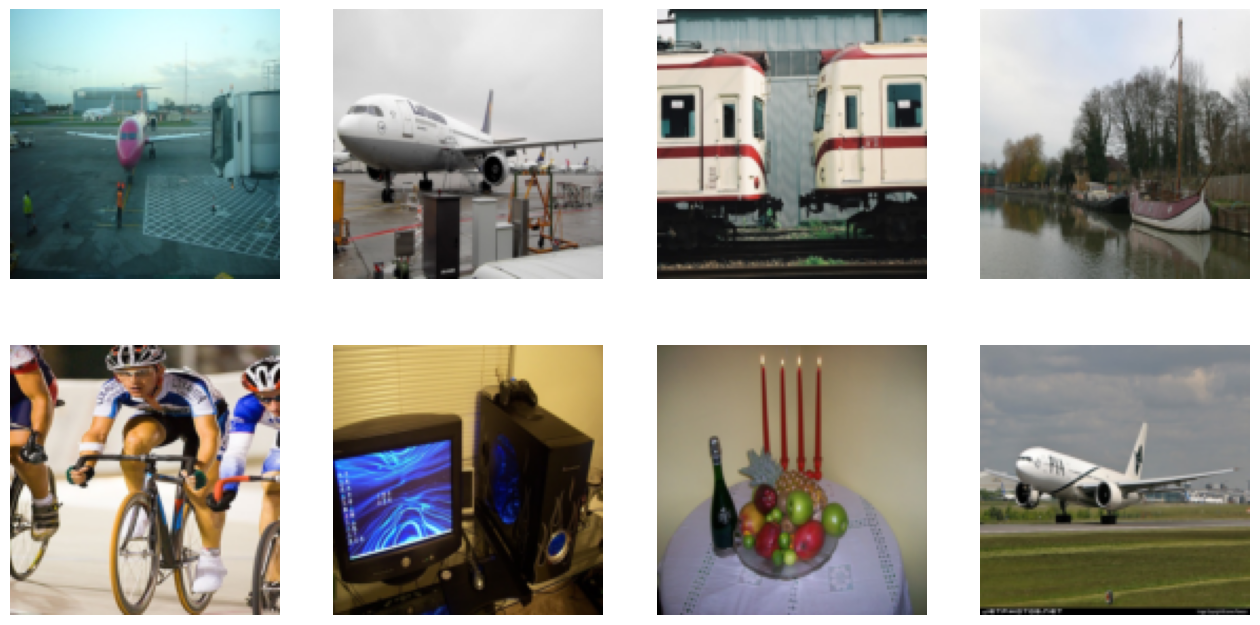

In [4]:
import math

def plot_images(images, num_per_row=4, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row,figsize=(4*num_per_row,4*num_rows))
    #fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image)
        ax.axis('off')

    return fig

# Echantilonnage du dataset de viz:

inputs, ground_truths = list(zip(*[train_dataset_viz[i] for i in range(8)]))

_ = plot_images(inputs)

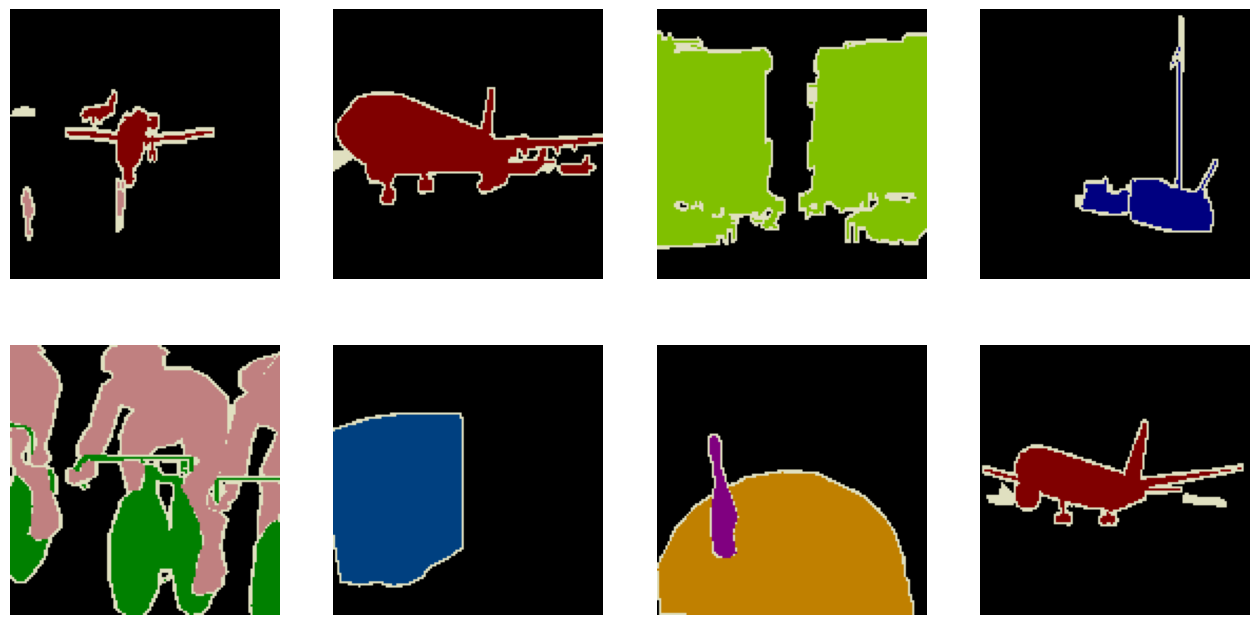

In [5]:
_ = plot_images(ground_truths)

**Question 1:** How many classes are there? \\
Search the web for the difference between semantic segmentation and instance segmentation. What type of segmentation is this dataset about?

In [ ]:
# num_classes = ...
# YOUR CODE HERE
num_classes = 21

YOUR ANSWER HERE

**B.** Presentation of an FCN-ResNet

In the next cell, we load an [FCN](https://pytorch.org/vision/stable/models/fcn.html) built from a [ResNet50](https://arxiv.org/pdf/1512.03385.pdf):

In [6]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights_backbone = None )
# fcn = torchvision.models.segmentation.fcn_resnet50( weights_backbone = torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

**Q2:** What is different from a standard ResNet50? Does the FCN provide an output of the same size as the input? Test and explain.

In [7]:
resnet50 =  torchvision.models.resnet50()
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
print(fcn)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In summary:
- The final perceptron is replaced by a fully convolutional "head" ([FCNhead](https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/fcn.py)).
- In the case of ResNet, the stride = 2 is replaced by dilation.
- The forward pass involves an interpolation step at the end.

In [9]:
# sample the dataset, convert to torch.tensor:
batch_size = 4
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize([64,64])
target_resize = transforms.Resize((64,64))

input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

In [10]:
def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

In [11]:
# Creation d'un dataset
train_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=False,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
inputs, targets  = next(iter(train_loader))

inputs = inputs
y = fcn(inputs)
print(y['out'].size())

torch.Size([4, 21, 64, 64])


The image size is mechanically preserved by interpolation. While a stride = 2 implies a spatial dimension reduction by half, this is not the case with a dilation = 2 / 4 (see this [illustration](https://github.com/vdumoulin/conv_arithmetic)). Thus, the spatial dimensions of the feature maps are less reduced than with the original ResNet50.

**C. Testing a Pretrained Network**

In this exercise, we simply **test** a model trained on another segmentation dataset. An extension to this exercise provides an opportunity to train the model introduced in exercise sheet #2.

In [12]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights='COCO_WITH_VOC_LABELS_V1')

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:10<00:00, 14.1MB/s]


In [13]:
batch_size = 16
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize((256,256))
target_resize = transforms.Resize((256,256))

input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
    ]
)

test_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=False,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

In [14]:
# Creating loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

**Q3:** According to the preceding code lines, which set (validation or test) of PascalVOC2007 are we testing the model on? Why?

YOUR ANSWER HERE

Now, let's visualize some model outputs on this set:

In [ ]:
# Color palette for segmentation masks
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)


def array1d_to_pil_image(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [ ]:
inputs, targets = next(iter(test_loader))
outputs = fcn(inputs)['out']
outputs = outputs.argmax(1)

outputs = replace_tensor_value_(outputs, 21, 255)
targets = replace_tensor_value_(targets, 21, 255)
targets = targets.squeeze(dim=1)

In [ ]:
plt_inputs = np.clip(inputs.numpy().transpose((0, 2, 3, 1)) * imagenet_std + imagenet_mean, 0, 1)
fig = plot_images(plt_inputs)
fig.suptitle("Images")

pil_outputs = [array1d_to_pil_image(out) for out in outputs.numpy()]
fig = plot_images(pil_outputs)
fig.suptitle("Predictions")

pil_targets = [array1d_to_pil_image(gt) for gt in targets.numpy()]
fig = plot_images(pil_targets)
_ = fig.suptitle("Ground truths")

Now, let's evaluate the model on the entire set.

In [ ]:
# For the test metric
!pip install torchmetrics

In [ ]:
import torchmetrics
IoU = torchmetrics.JaccardIndex(num_classes=21, ignore_index=255,task="multiclass")

Q4: Jaccard Index is used instead of accuracy. How is it defined? What is its other name? What is its advantage?

YOUR ANSWER HERE

Q5: Modify the following code to obtain an average IoU over the entire set

In [ ]:
fcn = fcn.to(device)
fcn.eval()
for i, (inputs, targets) in enumerate(test_loader):
  targets = targets.squeeze(dim=1)
  targets[targets==255]= 0
  inputs = inputs.to(device)
  targets = targets.to(device)
  outputs = fcn(inputs)['out']

  outputs = outputs.cpu()
  targets = targets.cpu()
  batch_IoU = IoU(outputs, targets)


**Exercise 2: Perfectly Supervised Denoising**

In a perfectly supervised denoising problem, we have two sets of images $B_{noisy}$ and $B_{clean}$.
Each clean image in $B_{clean}$ corresponds to a noisy version in $B_{noisy}$. \\
In this exercise, we will train an FCN to transform the noisy version into the clean one. To avoid using real data that would take up space on the drive, we work on synthetic images generated on the fly. We are thus in the ideal scenario where the datasets are infinitely large, and overfitting is not a concern.
In this context, data augmentation and validation steps are unnecessary, simplifying the training procedures.
The following cells visualize data from $B_{noisy}$ and their corresponding "clean" counterparts. The function $gen$ (in the module  **utile.py**) samples batches on the fly.

In [ ]:
! git clone https://github.com/relmonta/ml-student.git

In [ ]:
! cp ml-student/TP3/utile.py .

In [ ]:
from utile import *

input, target = gen(6)

# Noisy versions (filled and noisy rectangles)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# Clean versions (only cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0, max_scale=1)

The task is to remove the rectangles (filled or not) from the image. It is a well-posed but a priori challenging problem: spatial context is necessary to achieve it. To address this, we will use another popular FCN: a simplified [U-Net](https://arxiv.org/abs/1505.04597) (see utile.py).

In [ ]:
ch_in = 1
ch_out = 1
size = 16

fcn = UNet(ch_in, ch_out, size).to(device)  # 1 input channel, 1 output channel, network size parameter: 16

**Q1:** How many convolution layers does this U-Net contain? How many weights in total when $size = 16$?

In [ ]:
#print(fcn)
i=0
for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      i+=1

print(i)

pconv=0
pconvt=0
pbn=0
ptot=0

for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      for parameter in module.parameters():
        pconv += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.ConvTranspose2d):
      for parameter in module.parameters():
        pconvt += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.BatchNorm2d):
      for parameter in module.parameters():
        pbn += torch.numel(parameter)

print(pconv)  # number of weights in convolution layers
print(pconvt) #  " " in transpose convolution layers
print(pbn)    # number of weights in BatchNorm layers

print(pconv + pconvt + pbn)

**Q2:** For an input image with spatial dimensions $64\times 64$, what is the dimension of the intermediate feature map?

In [ ]:
fcn

The successive convolutions preserve the dimensions (due to "padding" - a layer of zeros on each side). The four successive maxpooling operations reduce the spatial dimensions to $4 \times 4$.

**Q3:** How is the multi-scale processing ensured? What is the purpose of "skip-connections"?

YOUR ANSWER HERE

**Q4:** Define a simple training procedure (no validation) using Mean Square Error (MSE) as the cost function and Adam as the optimization method (learning rate of 0.001). Once the training procedure is ready, associate a GPU with the notebook and ensure that the denoising task is well learned.

In [ ]:
fcn = fcn.to(device)

In [ ]:
def criterion(output, target):
    return torch.mean((output - target)**2)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 40  # brew a tea while waiting
nbatches = 100  # Number of batches per epoch
batchsize = 32  # Batch size

train_losses = []  # List to store training losses

fcn = fcn.to(device)

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        inputs, targets = gen(batchsize)
        # YOUR CODE HERE
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = fcn(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

In [ ]:
plt.plot(train_losses)

In [ ]:
#visualization:

fcn.eval()

target = make_batch(6, rec=0., noisy_rec=0., disc=0.002).to(device)
noise = make_batch(6, rec=0.0003, noisy_rec=0.0003, disc=0.).to(device)
input = target + noise

# output =

# YOUR CODE HERE
raise NotImplementedError()